In [1]:
import pandas as pd
from libkdv import kdv
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from scipy import linalg
from statsmodels.nonparametric.kernel_density import KDEMultivariate
import matplotlib.pyplot as plt
from KDEpy import FFTKDE
import numpy as np
import time
from KDEpy import FFTKDE,NaiveKDE
from libkdv.utils import GPS_to_XY

def kde_scipy(x, x_grid, **kwargs):
    """Kernel Density Estimation with Scipy"""
    if 'bandwidth' in kwargs:
        kwargs.pop('bandwidth')
    if 'kernel' in kwargs:
        kwargs.pop('kernel')
    kde = gaussian_kde(x, **kwargs)
    return kde.evaluate(x_grid)

def kde_statsmodels_m(x, x_grid, **kwargs):
    """Multivariate Kernel Density Estimation with Statsmodels"""
    if 'bandwidth' in kwargs:
        kwargs['bw'] = [kwargs['bandwidth'],kwargs['bandwidth']]
        kwargs.pop('bandwidth')
    if 'kernel' in kwargs:
        kwargs['kernel'] = kwargs['kernel'][:2]

    kde = KDEMultivariate([x[0],x[1]],
                          var_type='cc', **kwargs)
    return kde.pdf(x_grid)

def kde_sklearn(x, x_grid, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    x = x.T
    x_grid = x_grid.T
    kde = KernelDensity(**kwargs)
    kde.fit(x)
    log_pdf = kde.score_samples(x_grid)
    return np.exp(log_pdf)

def kde_libkdv(x,kernel,**kwargs):
    kde = kdv(x,GPS=False,**kwargs)
    return np.array(kde.compute()['val'])

class kde_exp:
    def __init__(self,name,func):
        self.func = func
        self.name = name
        self.results = {}
        
    def compute(self,data_name,points,bound=None,row_pixels=800,col_pixels=640,bandwidth=1000,kernel='epanechnikov'):
        if bound is None:
            bound = [points[0].min(),points[0].max(),points[1].min(),points[1].max()]
        tik = time.time()
        
        if self.func == kde_libkdv:
            Z = self.func(points,kernel,row_pixels=row_pixels,col_pixels=col_pixels,bandwidth=bandwidth)
        #elif self.func in [kde_Naive_kdepy,kde_FFT_kdepy]:
            
        #    Z = self.func(points.T,kernel,row_pixels=row_pixels,col_pixels=col_pixels,bandwidth=bandwidth,kernel=kernel)
        else:
            X = np.linspace(bound[0],bound[1],row_pixels)
            Y = np.linspace(bound[2],bound[3],col_pixels)
            X,Y = np.meshgrid(X,Y)
            positions = np.vstack([X.T.ravel(), Y.T.ravel()])
            Z = self.func(points,positions,bandwidth=bandwidth)
            
        tok = time.time()
        self.results[data_name] = {}
        self.results[data_name]['values'] = np.reshape(Z.T, [row_pixels,col_pixels])
        self.results[data_name]['time'] = tok-tik
        self.results[data_name]['bound'] = bound
        if self.func == kde_scipy:
            kernel = 'gaussian'
        self.results[data_name]['kernel'] = kernel
        return self.results[data_name]

In [ ]:
#load Seattle dataset
Seattle = pd.read_csv('..datasets/Seattle.csv')
middle_lat_Seattle = 43.796782
GPS_to_XY(Seattle,middle_lat_Seattle)

#Different KDE methods for conducting experiments
kde_names = ['libkdv','scipy','sklearn','statsmodels']
kde_funcs = [kde_libkdv,kde_scipy,kde_sklearn,kde_statsmodels_m]

kde_exps = []
for i in range(len(kde_names)):
    kde_exps.append(kde_exp(kde_names[i],kde_funcs[i]))

In [13]:
#LIBKDV (Sample 1% of data points)
points_1 = Seattle[['x','y']].head(8388).to_numpy().T

print('Method: %s'%kde_exps[0].name)
print('Dataset (Sample 1%% of the data points): %s'%('Seattle'))
kde_exps[0].compute('Seattle',points_1,bandwidth = 671,kernel = 'epanechnikov',row_pixels=1280,col_pixels=960)
print('Response time is: %.4ss'%(kde_exps[0].results['Seattle']['time']))

Method: libkdv
Dataset (Sample 1% of the data points): Seattle
Response time is: 3.49s


In [4]:
#Scipy (Sample 1% of data points)
points_1 = Seattle[['x','y']].head(8388).to_numpy().T

print('Method: %s'%kde_exps[1].name)
print('Dataset (Sample 1%% of the data points): %s'%('Seattle'))
kde_exps[1].compute('Seattle',points_1,bandwidth = 671,kernel = 'epanechnikov',row_pixels=1280,col_pixels=960)
print('Response time is: %.4ss'%(kde_exps[1].results['Seattle']['time']))

Method: scipy
Dataset (Sample 1% of the data points): Seattle
Response time is: 114.s


In [5]:
#Scikit-learn (Sample 1% of data points)
points_1 = Seattle[['x','y']].head(8388).to_numpy().T

print('Method: %s'%kde_exps[2].name)
print('Dataset (Sample 1%% of the data points): %s'%('Seattle'))
kde_exps[2].compute('Seattle',points_1,bandwidth = 671,kernel = 'epanechnikov',row_pixels=1280,col_pixels=960)
print('Response time is: %.4ss'%(kde_exps[2].results['Seattle']['time']))

Method: sklearn
Dataset (Sample 1% of the data points): Seattle
Response time is: 308.s


In [6]:
#Statsmodels (Sample 1% of data points)
points_1 = Seattle[['x','y']].head(8388).to_numpy().T

print('Method: %s'%kde_exps[3].name)
print('Dataset (Sample 1%% of the data points): %s'%('Seattle'))
kde_exps[3].compute('Seattle',points_1,bandwidth = 671,kernel = 'epanechnikov',row_pixels=1280,col_pixels=960)
print('Response time is: %.4ss'%(kde_exps[3].results['Seattle']['time']))

Method: statsmodels
Dataset (Sample 1% of the data points): Seattle
Response time is: 264.s


In [8]:
#Full data points
points_100 = Seattle[['x','y']].to_numpy().T

print('Method: %s'%kde_exps[0].name)
print('Dataset (Sample 100%% of the data points): %s'%('Seattle'))
kde_exps[0].compute('Seattle',points_100,bandwidth = 671,kernel = 'epanechnikov',row_pixels=1280,col_pixels=960)
print('Response time is: %.4ss'%(kde_exps[0].results['Seattle']['time']))

Method: libkdv
Dataset (Sample 100% of the data points): Seattle
Response time is: 12.6s


(5281719.948391012, 5307792.955917665)

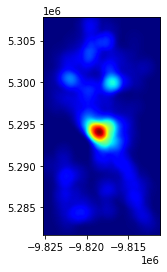

In [14]:
#Display the visualization
fig, ax = plt.subplots()
# color reference: https://matplotlib.org/stable/tutorials/colors/colormaps.html
ax.imshow(np.rot90(kde_exps[0].results['Seattle']['values']), cmap=plt.cm.jet, extent=kde_exps[0].results['Seattle']['bound'])
#ax.plot(datas[i][0],datas[i][1], 'k.', markersize=2)
#ax.set_title('Method:%s\nData:%s\nCompute time:%.3fs\nKernel:%s\n'%(exp.name,data_names[i],exp.results[data_names[i]]['time'],exp.results[data_names[i]]['kernel'] ))
ax.set_xlim(kde_exps[0].results['Seattle']['bound'][0:2])
ax.set_ylim(kde_exps[0].results['Seattle']['bound'][2:4])